Colab Verification


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


Drive Access

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

**Libraries**

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

**Loading Data Paths**

In [0]:
train_dir = "/content/drive/object_classification_tf_keras(leaf)/dataset/train"
validation_dir = "/content/drive/object_classification_tf_keras(leaf)/dataset/validation"

**Initial Variables**

In [0]:
batch_size = 128
epochs = 40
IMG_HEIGHT = 256
IMG_WIDTH = 256
num_classes = 4

**Data Preparation**

In [0]:
#Neural networks works better small values. 
#Small values increase learning speed because the learning speed decreases as
#derivative gets smaller as the value increases in the activation functions. 

#Augmentation + Rescale
train_image_generator = ImageDataGenerator(rotation_range=25, 
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           fill_mode="nearest",
                                           rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [89]:
# if binary classification class_mode = 'binary'
# if multiple classification class_mode = 'categorical'
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 3489 images belonging to 4 classes.
Found 669 images belonging to 4 classes.


**Create Model**

In [0]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (IMG_HEIGHT,IMG_HEIGHT,3)))
model.add(MaxPool2D())

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D())

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(4, activation = "softmax"))

**Optimizer Settings**

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Model Summary**

In [99]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 128)      

**Training Model**

In [0]:
filepath="/content/drive/object_classification_tf_keras(leaf)/log/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [101]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=[checkpoint]
)

Epoch 1/40
27/27 [==============================] - 62s 2s/step - loss: 1.0727 - accuracy: 0.5126 - val_loss: 1.2443 - val_accuracy: 0.5547

Epoch 00001: val_loss improved from inf to 1.24434, saving model to /content/drive/object_classification_tf_keras(leaf)/log/weights.best.hdf5
Epoch 2/40
27/27 [==============================] - 63s 2s/step - loss: 0.6184 - accuracy: 0.7581 - val_loss: 0.6827 - val_accuracy: 0.7006

Epoch 00002: val_loss improved from 1.24434 to 0.68272, saving model to /content/drive/object_classification_tf_keras(leaf)/log/weights.best.hdf5
Epoch 3/40
27/27 [==============================] - 60s 2s/step - loss: 0.4171 - accuracy: 0.8373 - val_loss: 0.7415 - val_accuracy: 0.7726

Epoch 00003: val_loss did not improve from 0.68272
Epoch 4/40
27/27 [==============================] - 59s 2s/step - loss: 0.3462 - accuracy: 0.8685 - val_loss: 0.9648 - val_accuracy: 0.7431

Epoch 00004: val_loss did not improve from 0.68272
Epoch 5/40
27/27 [============================

**Visualizing the results**

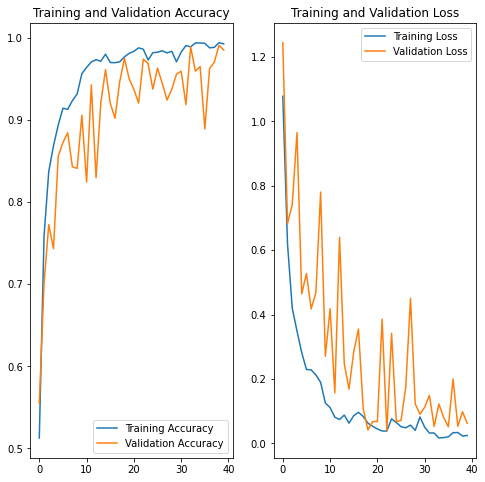

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Lets check model on 1 sample 


In [0]:
from keras.models import load_model
model = load_model("/content/drive/object_classification_tf_keras(leaf)/log/weights.best.hdf5")

In [140]:
image_path ="/content/drive/object_classification_tf_keras(leaf)/dataset/validation/Black_Rot/01d4aa8b-cc91-4475-b80c-b5b0ca10f1f6___FAM_B.Rot 3050.JPG"

img = Image.open(image_path)
img = tf.keras.preprocessing.image.array_to_img(img)
array = tf.keras.preprocessing.image.img_to_array(img)

array /=255
array = array.reshape(1,256,256,3)

predicted_class = model.predict_classes(array)
print(predicted_class)

[1]
